In [70]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from pyts.multivariate.classification import MultivariateClassifier
from pyts.classification import TimeSeriesForest
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, delayed
from sklearn.preprocessing import RobustScaler
from mpl_toolkits.mplot3d import Axes3D
import itertools
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
import plotly.graph_objects as go
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

**Loading Partition 1.**

In [2]:
main_folder_path = "/home/afrid/Documents/NASA/dataverse_files/partition1"
folder_name_1 = 'FL'
folder_name_2 = 'NF'
folder_path_1 = os.path.join(main_folder_path, folder_name_1)
folder_path_2 = os.path.join(main_folder_path, folder_name_2)
files_folder_1 = os.listdir(folder_path_1)
files_folder_2 = os.listdir(folder_path_2)


In [3]:
dfs_folder_1 = [pd.read_csv(os.path.join(folder_path_1, file), sep='\t', usecols=[1, 2, 3]).assign(Class=1) for file in files_folder_1]
dfs_folder_2 = [pd.read_csv(os.path.join(folder_path_2, file), sep='\t', usecols=[1, 2, 3]).assign(Class=0) for file in files_folder_2]

# Ensure the 'Class' column is of integer type
#for df in dfs_folder_1 + dfs_folder_2:
#    df['Class'] = df['Class'].astype(int)

In [4]:
data_folder_1 = np.stack([df.values for df in dfs_folder_1], axis=0)
data_folder_2 = np.stack([df.values for df in dfs_folder_2], axis=0)

print("Data types after loading CSV files:")
print(dfs_folder_1[0].dtypes)
print(dfs_folder_2[0].dtypes)

Data types after loading CSV files:
TOTUSJH    float64
TOTBSQ     float64
TOTPOT     float64
Class        int64
dtype: object
TOTUSJH    float64
TOTBSQ     float64
TOTPOT     float64
Class        int64
dtype: object


In [5]:
data_folder_1[:, :, -1] = data_folder_1[:, :, -1].astype(int)
data_folder_2[:, :, -1] = data_folder_2[:, :, -1].astype(int)


print("Data types after conversion:")
print(data_folder_1[:, :, -1].dtype)
print(data_folder_2[:, :, -1].dtype)

Data types after conversion:
float64
float64


In [6]:
final_data = np.concatenate([data_folder_1, data_folder_2], axis=0)

In [7]:
fifth_subarray = data_folder_1[4]

missing_values_present = np.isnan(fifth_subarray).any()

if missing_values_present:
    print("Missing values present in the 5th subarray of data_folder_1.")
else:
    print("No missing values in the 5th subarray of data_folder_1.")


Missing values present in the 5th subarray of data_folder_1.


In [8]:
subarrays_with_missing_values = []
for i, subarray in enumerate(final_data):
    missing_values_present = np.isnan(subarray).any()
    if missing_values_present:
        subarrays_with_missing_values.append(i)

In [9]:
subarrays_with_missing_values = []
for i, subarray in enumerate(final_data):
    subarray = np.array(subarray)
    missing_values_present = np.isnan(subarray)
    if np.any(missing_values_present):
        subarrays_with_missing_values.append(i)
        column_means = np.nanmean(subarray, axis=0)
        for j in range(subarray.shape[1]):
            subarray[:, j][missing_values_present[:, j]] = column_means[j]
        final_data[i] = subarray.tolist()

In [10]:
missing_values_per_array = [
    np.any(np.isnan(array)) for array in final_data
]

In [11]:
data_folder_1.shape

(1254, 60, 4)

In [12]:
data_folder_2.shape

(72238, 60, 4)

In [13]:
final_data.shape

(73492, 60, 4)

**Loading Partition 2.**

In [14]:

main_folder_path_p2 = "/home/afrid/Documents/NASA/dataverse_files/partition2"
folder_name_FL_p2 = 'FL'
folder_name_NF_p2 = 'NF'

folder_path_FL_p2 = os.path.join(main_folder_path_p2, folder_name_FL_p2)
folder_path_NF_p2 = os.path.join(main_folder_path_p2, folder_name_NF_p2)
files_FL_p2 = os.listdir(folder_path_FL_p2)
files_NF_p2 = os.listdir(folder_path_NF_p2)


In [15]:
dfs_FL_p2 = [pd.read_csv(os.path.join(folder_path_FL_p2, file), sep='\t', usecols=[1, 2, 3]).assign(Class=1) for file in files_FL_p2]
dfs_NF_p2 = [pd.read_csv(os.path.join(folder_path_NF_p2, file), sep='\t', usecols=[1, 2, 3]).assign(Class=0) for file in files_NF_p2]
data_FL_p2 = np.stack([df.values for df in dfs_FL_p2], axis=0)
data_NF_p2 = np.stack([df.values for df in dfs_NF_p2], axis=0)
data_FL_p2[:, :, -1] = data_FL_p2[:, :, -1].astype(int)
data_NF_p2[:, :, -1] = data_NF_p2[:, :, -1].astype(int)

In [16]:
final_data_p2 = np.concatenate([data_FL_p2, data_NF_p2], axis=0)

In [17]:
subarrays_with_missing_values_NF_p2 = []

for i, subarray in enumerate(final_data_p2):
    subarray_NF_p2 = np.array(subarray)
    missing_values_present_NF_p2 = np.isnan(subarray_NF_p2)

    if np.any(missing_values_present_NF_p2):
        subarrays_with_missing_values_NF_p2.append(i)
        column_means_NF_p2 = np.nanmean(subarray_NF_p2, axis=0)
        for j_NF_p2 in range(subarray_NF_p2.shape[1]):
            subarray_NF_p2[:, j_NF_p2][missing_values_present_NF_p2[:, j_NF_p2]] = column_means_NF_p2[j_NF_p2]
        final_data_p2[i] = subarray_NF_p2.tolist()

**Sampling.**


partition 1

In [18]:

class_labels = final_data[:, 0, -1]
class_0_indices = np.where(class_labels == 0)[0]
class_1_indices = np.where(class_labels == 1)[0]
selected_class_0_indices = class_0_indices[:len(class_1_indices)]
selected_indices = np.concatenate([class_1_indices, selected_class_0_indices])
final_train_data = final_data[selected_indices]
final_train_data[:, 0, -1] = final_train_data[:, 0, -1].astype(int)

print(final_train_data.shape)

(2508, 60, 4)


Model Example.

In [19]:
X_train = final_train_data[:, :, :-1]
y_train = final_train_data[:, 0, -1]

X_test = final_data_p2[:, :, :-1]
y_test = final_data_p2[:, 0, -1]

In [20]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [21]:
y_test.shape

(88558,)

In [22]:
X_train.shape
X_test.shape
y_train.shape
y_test.shape

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2508, 60, 3)
(88558, 60, 3)
(2508,)
(88558,)


In [23]:
# Check for NaN values in X_train
nan_in_x_train = np.isnan(X_train)
any_nan_in_x_train = np.any(nan_in_x_train)

# Check for NaN values in X_test
nan_in_x_test = np.isnan(X_test)
any_nan_in_x_test = np.any(nan_in_x_test)

print(f'Any NaN in X_train: {any_nan_in_x_train}')
print(f'Any NaN in X_test: {any_nan_in_x_test}')

Any NaN in X_train: False
Any NaN in X_test: False


In [24]:
np.unique(y_test)


array([0, 1])

In [25]:
#X_train

In [26]:
scaler = RobustScaler()



In [27]:
'''def tss_score(estimator, X, y):
    y_pred = estimator.predict(X)
    cm = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = cm.ravel()
    P = TP + FN
    N = FP + TN
    return (TP / P) - (FP / N) if (P > 0 and N > 0) else 0'''

'def tss_score(estimator, X, y):\n    y_pred = estimator.predict(X)\n    cm = confusion_matrix(y, y_pred)\n    TN, FP, FN, TP = cm.ravel()\n    P = TP + FN\n    N = FP + TN\n    return (TP / P) - (FP / N) if (P > 0 and N > 0) else 0'

In [33]:
'''# Modify the tss_score function to take y_true and y_pred only
def tss_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    if cm.shape[0] == cm.shape[1]:
        n_classes = cm.shape[0]
        tss_total = 0
        for i in range(n_classes):
            tp = cm[i, i]
            fn = cm[i, :].sum() - tp
            fp = cm[:, i].sum() - tp
            tn = cm.sum() - tp - fn - fp

            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            tss = sensitivity - (1 - specificity)

            tss_total += tss

        return tss_total / n_classes
    else:
        print("Error: Confusion matrix is not square.")
        return 0'''


'''def tss_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    if cm.shape[0] == cm.shape[1]:
        n_classes = cm.shape[0]
        tss_total = 0
        for i in range(n_classes):
            tp = cm[i, i]
            fn = cm[i, :].sum() - tp
            fp = cm[:, i].sum() - tp
            tn = cm.sum() - tp - fn - fp

            sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
            #specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
            #tss = sensitivity - (1 - specificity)
            fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
            tss = sensitivity - fpr

            tss_total += tss

        return tss_total #/ n_classes
    else:
        print("Error: Confusion matrix is not square.")
        return 0'''

'''def custom_scorer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    if cm.shape == (2, 2):
        tp = cm[1, 1]
        fn = cm[1, 0]
        fp = cm[0, 1]
        tn = cm[0, 0]

        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        tss = sensitivity - fpr

        return tss
    elif cm.shape == (1, 1):
        return 1 if y_true[0] == y_pred[0] else 0
    else:
        print(f"Error: Confusion matrix shape {cm.shape} is not handled.")
        return 0


custom_scorer = make_scorer(tss_score, greater_is_better=True)'''

'def custom_scorer(y_true, y_pred):\n    cm = confusion_matrix(y_true, y_pred)\n\n    if cm.shape == (2, 2):\n        tp = cm[1, 1]\n        fn = cm[1, 0]\n        fp = cm[0, 1]\n        tn = cm[0, 0]\n\n        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0\n        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0\n        tss = sensitivity - fpr\n\n        return tss\n    elif cm.shape == (1, 1):\n        return 1 if y_true[0] == y_pred[0] else 0\n    else:\n        print(f"Error: Confusion matrix shape {cm.shape} is not handled.")\n        return 0\n\n\ncustom_scorer = make_scorer(tss_score, greater_is_better=True)'

In [34]:
def custom_scorer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    if cm.shape == (2, 2):
        tp = cm[1, 1]
        fn = cm[1, 0]
        fp = cm[0, 1]
        tn = cm[0, 0]

        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        tss = sensitivity - fpr

        p = tp + fn
        n = fp + tn
        hss = (2 * ((tp * tn) - (fn * fp))) / ((p * (fn + tn)) + (n * (tp + fp)))

        return tss, hss
    elif cm.shape == (1, 1):
        return 1 if y_true[0] == y_pred[0] else 0, 0
    else:
        print(f"Error: Confusion matrix shape {cm.shape} is not handled.")
        return 0, 0


tss_scorer = make_scorer(lambda y_true, y_pred: custom_scorer(y_true, y_pred)[0], greater_is_better=True)
hss_scorer = make_scorer(lambda y_true, y_pred: custom_scorer(y_true, y_pred)[1], greater_is_better=True)


In [40]:
param_grid = {
    'estimator__n_estimators': [50, 100],
    'estimator__n_windows': [5, 10],#, 15],
    'estimator__min_window_size': [1],# 2],
    'estimator__criterion': ['entropy'],#, 'gini'],
    'estimator__max_depth': [5, 10]#, 20],
}

In [41]:
'''# Assuming X_train and X_test are 3D arrays with shape (n_samples, n_timestamps, n_features)
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Now apply RobustScaler
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_test_scaled_2d = scaler.transform(X_test_2d)

# Reshape back to 3D
X_train_scaled = X_train_scaled_2d.reshape(X_train.shape)
X_test_scaled = X_test_scaled_2d.reshape(X_test.shape)'''


'# Assuming X_train and X_test are 3D arrays with shape (n_samples, n_timestamps, n_features)\nX_train_2d = X_train.reshape(X_train.shape[0], -1)\nX_test_2d = X_test.reshape(X_test.shape[0], -1)\n\n# Now apply RobustScaler\nX_train_scaled_2d = scaler.fit_transform(X_train_2d)\nX_test_scaled_2d = scaler.transform(X_test_2d)\n\n# Reshape back to 3D\nX_train_scaled = X_train_scaled_2d.reshape(X_train.shape)\nX_test_scaled = X_test_scaled_2d.reshape(X_test.shape)'

**k-fold.**

In [42]:
clf = MultivariateClassifier(estimator=TimeSeriesForest(random_state=53))

n_folds = 5
#tscv = TimeSeriesSplit(n_splits=n_splits)

kf = KFold(n_splits=n_folds, shuffle=True, random_state=53)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring={'tss': tss_scorer, 'hss': hss_scorer}, 
    refit='tss',
    cv=kf,  
    n_jobs=-1,  
)

In [43]:

grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=53, shuffle=True),
             estimator=MultivariateClassifier(estimator=TimeSeriesForest(random_state=53)),
             n_jobs=-1,
             param_grid={'estimator__criterion': ['entropy'],
                         'estimator__max_depth': [5, 10],
                         'estimator__min_window_size': [1],
                         'estimator__n_estimators': [50, 100],
                         'estimator__n_windows': [5, 10]},
             refit='tss',
             scoring={'hss': make_scorer(<lambda>),
                      'tss': make_scorer(<lambda>)})

In [44]:
'''#clf = MultivariateClassifier(estimator=TimeSeriesForest(n_estimators=100,n_windows=5, 
                                                        max_depth=5, 
                                                        min_window_size=2, 
                                                        random_state=53))
#clf.fit(X_train_scaled, y_train)'''

'#clf = MultivariateClassifier(estimator=TimeSeriesForest(n_estimators=100,n_windows=5, \n                                                        max_depth=5, \n                                                        min_window_size=2, \n                                                        random_state=53))\n#clf.fit(X_train_scaled, y_train)'

In [46]:
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold_idx + 1}:")
    print(f"Training indices: {train_idx}")
    print(f"Testing indices: {test_idx}")
    print()

Fold 1:
Training indices: [   0    2    3 ... 2504 2505 2507]
Testing indices: [   1    7   16   17   28   29   42   46   47   50   53   56   57   60
   65   67   69   83   88   95   96  103  105  108  114  118  123  124
  125  129  132  134  136  138  139  146  153  155  162  163  166  167
  171  174  182  184  186  194  199  204  207  221  229  236  241  243
  256  259  267  274  281  282  289  290  295  296  298  302  304  305
  312  314  315  329  331  337  345  357  359  362  365  366  369  373
  375  376  380  384  389  392  399  402  415  438  440  452  454  458
  459  462  463  466  470  471  481  485  499  509  513  524  525  527
  535  536  537  544  545  548  550  555  556  557  563  568  575  577
  579  581  583  586  590  605  606  608  622  632  633  640  641  650
  659  660  671  673  679  680  687  692  708  710  717  741  759  766
  773  779  780  781  791  792  793  799  805  810  811  816  823  824
  834  843  849  861  863  865  868  869  888  894  896  904  907  91

In [45]:
'''for split_idx, (train_idx, test_idx) in enumerate(tscv.split(X_train)):
    print(f'Split {split_idx + 1}:')
    print(f'Training indices: {train_idx}')
    print(f'Testing indices: {test_idx}')
    print()'''

"for split_idx, (train_idx, test_idx) in enumerate(tscv.split(X_train)):\n    print(f'Split {split_idx + 1}:')\n    print(f'Training indices: {train_idx}')\n    print(f'Testing indices: {test_idx}')\n    print()"

In [47]:


for split_idx, (train_idx, test_idx) in enumerate(kf.split(X_train)):
    X_train_split, X_test_split = X_train[train_idx], X_train[test_idx]
    y_train_split, y_test_split = y_train[train_idx], y_train[test_idx]
    grid_search.best_estimator_.fit(X_train_split, y_train_split)
    y_pred_split = grid_search.best_estimator_.predict(X_test_split)

    cm = confusion_matrix(y_test_split, y_pred_split)
    print(f'Confusion Matrix for Split {split_idx + 1}:\n{cm}')
    print()


Confusion Matrix for Split 1:
[[217  42]
 [ 10 233]]

Confusion Matrix for Split 2:
[[206  45]
 [ 19 232]]

Confusion Matrix for Split 3:
[[222  42]
 [ 17 221]]

Confusion Matrix for Split 4:
[[228  17]
 [ 15 241]]

Confusion Matrix for Split 5:
[[201  34]
 [ 18 248]]



In [48]:
indices_class_1 = [idx for idx, label in enumerate(y_train) if label == 1]
indices_class_0 = [idx for idx, label in enumerate(y_train) if label == 0]

print(f'Indices for class label 1: {indices_class_1}')
print(f'Indices for class label 0: {indices_class_0}')


Indices for class label 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 21

In [49]:
#y_pred = clf.predict(X_test_scaled)

In [50]:
results_df = pd.DataFrame(grid_search.cv_results_)

In [51]:
results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_estimator__criterion', 'param_estimator__max_depth',
       'param_estimator__min_window_size', 'param_estimator__n_estimators',
       'param_estimator__n_windows', 'params', 'split0_test_tss',
       'split1_test_tss', 'split2_test_tss', 'split3_test_tss',
       'split4_test_tss', 'mean_test_tss', 'std_test_tss', 'rank_test_tss',
       'split0_test_hss', 'split1_test_hss', 'split2_test_hss',
       'split3_test_hss', 'split4_test_hss', 'mean_test_hss', 'std_test_hss',
       'rank_test_hss'],
      dtype='object')

In [52]:
print(results_df.iloc[:, 10:35].head().to_string())

   split0_test_tss  split1_test_tss  split2_test_tss  split3_test_tss  split4_test_tss  mean_test_tss  std_test_tss  rank_test_tss  split0_test_hss  split1_test_hss  split2_test_hss  split3_test_hss  split4_test_hss  mean_test_hss  std_test_hss  rank_test_hss
0         0.771486         0.705179         0.764451         0.820711         0.766085       0.765583      0.036672              8         0.769334         0.705179         0.761301         0.820351         0.767227       0.764679      0.036549              8
1         0.779462         0.713147         0.763210         0.832781         0.777860       0.773292      0.038254              5         0.777288         0.713147         0.761005         0.832343         0.779212       0.772599      0.038220              5
2         0.771486         0.709163         0.756048         0.828699         0.766085       0.766296      0.038184              7         0.769334         0.709163         0.753243         0.828336         0.767227     

In [53]:
print(results_df.to_string())

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_estimator__criterion param_estimator__max_depth param_estimator__min_window_size param_estimator__n_estimators param_estimator__n_windows                                                                                                                                                        params  split0_test_tss  split1_test_tss  split2_test_tss  split3_test_tss  split4_test_tss  mean_test_tss  std_test_tss  rank_test_tss  split0_test_hss  split1_test_hss  split2_test_hss  split3_test_hss  split4_test_hss  mean_test_hss  std_test_hss  rank_test_hss
0      12.682140      0.197545         1.197250        0.088139                    entropy                          5                                1                            50                          5     {'estimator__criterion': 'entropy', 'estimator__max_depth': 5, 'estimator__min_window_size': 1, 'estimator__n_estimators': 50, 'estimator__n_windows': 5}         0.

In [59]:

print("Best Parameters:", grid_search.best_params_)
print("Best TSS:", grid_search.best_score_)

best_hss_score = results_df.loc[grid_search.best_index_, 'mean_test_hss']
print("Best HSS:", best_hss_score)

Best Parameters: {'estimator__criterion': 'entropy', 'estimator__max_depth': 10, 'estimator__min_window_size': 1, 'estimator__n_estimators': 100, 'estimator__n_windows': 10}
Best TSS: 0.7941708970328791
Best HSS: 0.7933915356265968


In [60]:
grid_search.best_params_

{'estimator__criterion': 'entropy',
 'estimator__max_depth': 10,
 'estimator__min_window_size': 1,
 'estimator__n_estimators': 100,
 'estimator__n_windows': 10}

In [61]:
grid_search.best_score_

0.7941708970328791

In [62]:
best_model = grid_search.best_estimator_

In [64]:
y_pred = best_model.predict(X_test)

Test TSS: 0.7560792169012502
Test HSS: 0.14473901375525228
Confusion Matrix:


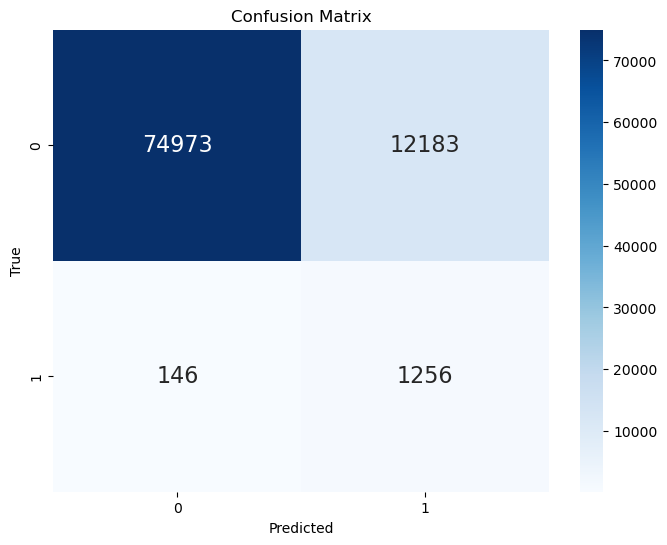

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     87156
           1       0.09      0.90      0.17      1402

    accuracy                           0.86     88558
   macro avg       0.55      0.88      0.55     88558
weighted avg       0.98      0.86      0.91     88558



In [69]:
test_tss, test_hss = custom_scorer(y_test, y_pred)
print(f"Test TSS: {test_tss}")
print(f"Test HSS: {test_hss}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
#print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

**Stratified CV.**

In [79]:
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=53)

grid_search_stratified = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring={'tss': tss_scorer, 'hss': hss_scorer}, 
    refit='tss',
    cv=skf,  
    n_jobs=-1,  
)

In [80]:

grid_search_stratified.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=53, shuffle=True),
             estimator=MultivariateClassifier(estimator=TimeSeriesForest(random_state=53)),
             n_jobs=-1,
             param_grid={'estimator__criterion': ['entropy'],
                         'estimator__max_depth': [5, 10],
                         'estimator__min_window_size': [1],
                         'estimator__n_estimators': [50, 100],
                         'estimator__n_windows': [5, 10]},
             refit='tss',
             scoring={'hss': make_scorer(<lambda>),
                      'tss': make_scorer(<lambda>)})

In [ ]:
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold_idx + 1}:")
    print(f"Training indices: {train_idx}")
    print(f"Testing indices: {test_idx}")
    print()

In [81]:
results_stratified = pd.DataFrame(grid_search_stratified.cv_results_)

print("Best Parameters:", grid_search_stratified.best_params_)
print("Best TSS:", grid_search_stratified.best_score_)

best_hss_score_strat = results_stratified.loc[grid_search_stratified.best_index_, 'mean_test_hss']
print("Best HSS:", best_hss_score_strat)

Best Parameters: {'estimator__criterion': 'entropy', 'estimator__max_depth': 10, 'estimator__min_window_size': 1, 'estimator__n_estimators': 100, 'estimator__n_windows': 10}
Best TSS: 0.8014374501992032
Best HSS: 0.8014295884638039


In [88]:
results_stratified.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_estimator__criterion', 'param_estimator__max_depth',
       'param_estimator__min_window_size', 'param_estimator__n_estimators',
       'param_estimator__n_windows', 'params', 'split0_test_tss',
       'split1_test_tss', 'split2_test_tss', 'split3_test_tss',
       'split4_test_tss', 'mean_test_tss', 'std_test_tss', 'rank_test_tss',
       'split0_test_hss', 'split1_test_hss', 'split2_test_hss',
       'split3_test_hss', 'split4_test_hss', 'mean_test_hss', 'std_test_hss',
       'rank_test_hss'],
      dtype='object')

In [84]:
best_model_strat = grid_search_stratified.best_estimator_
y_pred_strat = best_model_strat.predict(X_test)

Test TSS: 0.760001152932918
Test HSS: 0.1421198285791264
Confusion Matrix:


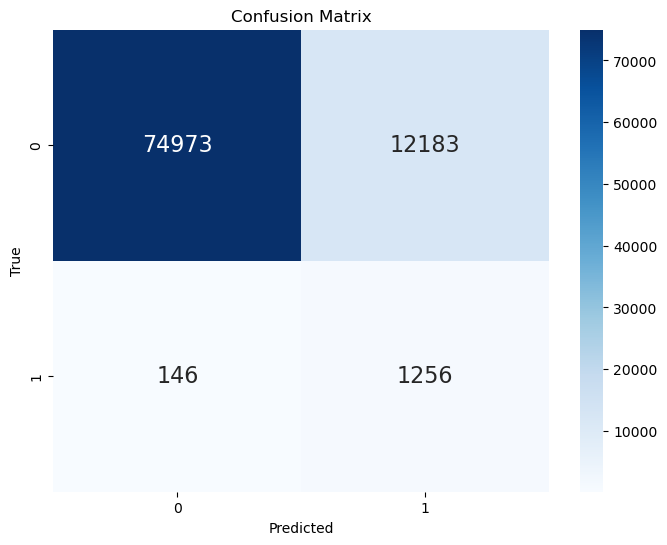

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     87156
           1       0.09      0.90      0.17      1402

    accuracy                           0.86     88558
   macro avg       0.55      0.88      0.54     88558
weighted avg       0.98      0.86      0.91     88558



In [85]:
strat_tss, strat_hss = custom_scorer(y_test, y_pred_strat)
print(f"Test TSS: {strat_tss}")
print(f"Test HSS: {strat_hss}")

cm_strat = confusion_matrix(y_test, y_pred_strat)
print("Confusion Matrix:")
#print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print the classification report
report_strat = classification_report(y_test, y_pred_strat)
print("Classification Report:")
print(report_strat)

In [94]:
tss_columns_kfold = [f'split{i}_test_tss' for i in range(5)]  # Assuming 5 splits
hss_columns_kfold = [f'split{i}_test_hss' for i in range(5)]

# Assuming you have the DataFrame results_stratified for Stratified K-Fold
# Extract TSS and HSS scores for each split
tss_columns_stratified = [f'split{i}_test_tss' for i in range(5)]  # Assuming 5 splits
hss_columns_stratified = [f'split{i}_test_hss' for i in range(5)]


hss_columns_stratified


['split0_test_hss',
 'split1_test_hss',
 'split2_test_hss',
 'split3_test_hss',
 'split4_test_hss']

In [97]:
# Combine scores across splits
tss_scores_kfold = results_df[tss_columns_kfold].mean(axis=0)
hss_scores_kfold = results_df[hss_columns_kfold].mean(axis=0)

tss_scores_stratified = results_stratified[tss_columns_stratified].mean(axis=0)
hss_scores_stratified = results_stratified[hss_columns_stratified].mean(axis=0)


tss_scores_kfold

split0_test_tss    0.784086
split1_test_tss    0.726096
split2_test_tss    0.765080
split3_test_tss    0.846809
split4_test_tss    0.779279
dtype: float64

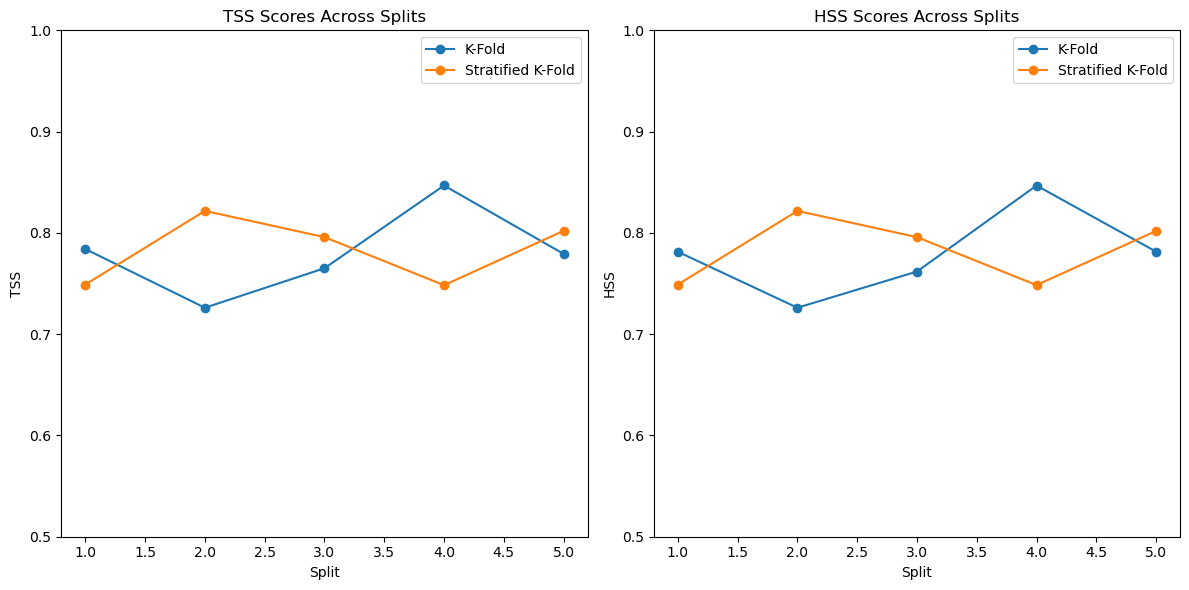

In [101]:
splits_kfold = np.arange(1, len(tss_scores_kfold) + 1)
splits_stratified = np.arange(1, len(tss_scores_stratified) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(splits_kfold, tss_scores_kfold, label='K-Fold', marker='o')
plt.plot(splits_stratified, tss_scores_stratified, label='Stratified K-Fold', marker='o')
plt.title('TSS Scores Across Splits')
plt.xlabel('Split')
plt.ylabel('TSS')
plt.legend()
plt.ylim([0.5, 1]) 

# Plot HSS scores
plt.subplot(1, 2, 2)
plt.plot(splits_kfold, hss_scores_kfold, label='K-Fold', marker='o')
plt.plot(splits_stratified, hss_scores_stratified, label='Stratified K-Fold', marker='o')
plt.title('HSS Scores Across Splits')
plt.xlabel('Split')
plt.ylabel('HSS')
plt.legend()
plt.ylim([0.5, 1]) 

plt.tight_layout()
plt.show()

In [102]:
# Function to plot confusion matrix
def plot_confusion(y_true, y_pred, method):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix - {method}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Assuming y_true_kfold, y_pred_kfold, y_true_stratified, y_pred_stratified are defined for each fold

# Plot confusion matrices for each fold
for i in range(len(y_test)):
    plot_confusion(y_test[i], y_pred[i], method='K-Fold, Split {}'.format(i + 1))

for i in range(len(y_test)):
    plot_confusion(y_test[i], y_pred_strat[i], method='Stratified K-Fold, Split {}'.format(i + 1))


InvalidParameterError: The 'y_true' parameter of confusion_matrix must be an array-like. Got 1 instead.

In [57]:
heatmap_data = results_df[['param_estimator__criterion', 'param_estimator__max_depth',
                            'param_estimator__min_window_size', 'param_estimator__n_estimators',
                            'param_estimator__n_windows', 'mean_test_score']]


heatmap_data_pivot = heatmap_data.pivot_table(index=['param_estimator__max_depth', 'param_estimator__n_estimators'],
                                              columns=['param_estimator__min_window_size', 'param_estimator__n_windows'],
                                              values='mean_test_score', aggfunc='mean')


plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_pivot, annot=True, cmap='RdBu_r', fmt=".3f", vmin=-1, vmax=1, cbar_kws={'label': 'Mean TSS Score'})
plt.title('TSS Score Across Parameter Combinations')
plt.show()


KeyError: "['mean_test_score'] not in index"

In [58]:
param_combinations = grid_search.cv_results_['params']
tss_values = grid_search.cv_results_['mean_test_score']

n_windows_values = [comb['estimator__n_windows'] for comb in param_combinations]
n_estimators_values = [comb['estimator__n_estimators'] for comb in param_combinations]

labels = [f"N Windows: {n_windows}, N Estimators: {n_estimators}, TSS: {tss}" 
          for n_windows, n_estimators, tss in zip(n_windows_values, n_estimators_values, tss_values)]

fig = go.Figure(data=[go.Scatter3d(x=n_windows_values, y=n_estimators_values, z=tss_values, mode='markers',
                                   marker=dict(color=tss_values, colorscale='Viridis', colorbar=dict(title='TSS')),
                                   text=labels, hoverinfo='text')])

fig.update_layout(scene=dict(xaxis_title='N Windows', yaxis_title='N Estimators', zaxis_title='TSS'))

fig.show()

KeyError: 'mean_test_score'

In [88]:
def hss_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    P = TP + FN
    N = FP + TN
    return (2 * ((TP * TN) - (FN * FP))) / ( (P * (FN + TN)) + (N * (TP + FP)) )

In [94]:
n_estimators_values = [100, 200, 300]
n_windows_values = [5]
max_depth_values = [None]

results = {"params": [], "tss_scores": [], "hss_scores": []}

for n_estimators in n_estimators_values:
    for n_windows in n_windows_values:
        for max_depth in max_depth_values:
            clf = MultivariateClassifier(estimator=TimeSeriesForest(
                n_estimators=n_estimators, n_windows=n_windows, max_depth=max_depth,random_state=53
            ))
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            tss = tss_score(y_test, y_pred)
            hss = hss_score(y_test, y_pred)
            results["params"].append({
                "n_estimators": n_estimators,
                "n_windows": n_windows,
                "max_depth": max_depth
            })
            results["tss_scores"].append(tss)
            results["hss_scores"].append(hss)
            print(f"Parameters: {results['params'][-1]}")
            print(f"TSS score: {tss:.3f}") 
            print(f"HSS score: {hss:.3f}\n")

Parameters: {'n_estimators': 100, 'n_windows': 5, 'max_depth': None}
TSS score: 0.744
HSS score: 0.139

Parameters: {'n_estimators': 200, 'n_windows': 5, 'max_depth': None}
TSS score: 0.740
HSS score: 0.138

Parameters: {'n_estimators': 300, 'n_windows': 5, 'max_depth': None}
TSS score: 0.743
HSS score: 0.138



In [ ]:
best_model = grid_search.best_estimator_